# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Домашнее задание 11

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков можно использовать без ограничений.**

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

<b><font color="blue">Легкая часть</font></b> (достаточно на "хор"):
* Задача 1 &mdash;  50 баллов

<b><font color="orange">Сложная часть</font></b> (необходимо на "отл"):
* Задача 2 &mdash;  40 баллов







-----

In [2]:
# Bot check

# HW_ID: phds_hw11
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


Импорты из sklearn:

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## Задача 1

In [3]:
def plot_results(y_to_train, y_to_test, y_forecast, title, is_with_test = True): 
    """
    Функция для визуализации временного ряда и предсказания.
    Параметры:
        - y_to_train: pd.Series размер T_train
            Временной ряд, на котором обучалась модель.
        - y_to_test: pd.Series размер T_test
            Временной ряд, который предсказывает модель.
        - y_forecast: array размер T_test
            Предсказания модели.
        - title: str
            Название графика
    """
    
    plt.figure(figsize=(15, 5))
    plt.title(title, fontsize=15) 
    if is_with_test:
        plt.plot(y_to_train, label="train")
        plt.plot(y_to_test, label="test")
        plt.plot(y_to_test.index, y_forecast, label="prediction") 
    else: 
        plt.plot(y_to_train)
    plt.legend()
    plt.show();

def calc_metrics(y_true, y_pred):
    """
    Функция для подсчета метрик качества прогноза
    Параметры:
        - y_true: np.array, pd.Series,  размер T_test
            Вектор истинных значений таргета
        - y_pred: np.array, pd.Series, размер T_test
            Векотр предсказанных знаяений таргета
    """

    print('MSE: ', mean_squared_error(y_true, y_pred))
    print('MAE: ', mean_absolute_error(y_true, y_pred))
    print('MAPE: ', mean_absolute_percentage_error(y_true, y_pred))


def create_date_features(date):
    """Создает фичи из даты"""
    
    row = {}
    row['dayofweek'] = date.dayofweek
    row['quarter'] = date.quarter
    row['month'] = date.month
    row['year'] = date.year
    row['dayofyear'] = date.dayofyear
    row['dayofmonth'] = date.day
    row['weekofyear'] = date.weekofyear
    return row


def create_only_date_train_features(y_series):
    """
        Создает обучающий датасет из признаков, полученных из дат для y_series
    """
    
    time_features = pd.DataFrame([create_date_features(date) for date in y_series.index])
    return time_features, y_series


def create_shifted_features(
    y_series, shifts=5, week_seasonal_shifts=1, year_seasonal_shifts=1
):
    """
    Создает обучающий датасет из признаков, полученных из дат и значений ряда ранее.
    При этом используются значения ряда со сдвигами на неделю и год назад.
    Параметры:
        - y_series: pd.Series, размер T
            временной ряд.
        - shifts: int
            дневной сдвиг (сколько дней учитываем).
        - week_seasonal_shifts: int
            недельный сдвиг (сколько недель учитываем).
        - year_seasonal_shifts: int
            годовой сдвиг (сколько лет учитываем).
    """
    
    curr_df, y = create_only_date_train_features(y_series)
    curr_df.index = y_series.index
    
    for target in y_series.columns[4:]:

        # применяем сдвиг по дням
        for shift in range(1, shifts + 1):
            curr_df[f'{target}_shift_{shift}'] = y_series[target].shift(shift * 24, axis=0)

        # применяем сдвиг по неделям
        for shift in range(1, week_seasonal_shifts + 1):
            curr_df[f"{target}_week_seasonal_shift_{shift}"] = y_series[target].shift(
                shift * 24 * 7, axis=0
            )

        # применяем сдвиг по годам
        for shift in range(1, year_seasonal_shifts + 1):
            curr_df[f"{target}_year_seasonal_shift_{shift}"] = y_series[target].shift(
                shift * 24 * 365, axis=0
            )

    y = y_series
    
    # удалим первые строчки с nan
    drop_indices = curr_df.index[curr_df.isna().sum(axis=1) > 0]
    curr_df = curr_df.drop(index=drop_indices)
    y = y.drop(index=drop_indices)
    return curr_df, y




def recursive_prediction(model, test_dates, y_to_train, features_creation_function):
    """
    Функция для рекурсивного предсказания для дат, указанных в test_dates.
    
    Параметры:
        - model
            Обученная МЛ-модель.
        - test_dates
            массив с датами, в которые надо сделать предсказания.
        - y_to_train
            Предыдущие значения
        - features_creation_function
            функция для создания тестовых признаков
    """

    predictions = []
    previous_y = list(y_to_train)
    
    for date in test_dates:

        # получаем признаки для тестовых данных из тестовой даты и предыдущих значений
        row = features_creation_function(date, previous_y)
        curr_test = pd.DataFrame([row])

        # выоплняем предсказание моделью
        curr_prediction = model.predict(curr_test)[0]

        # добавляем текущее предсказание к предыдущем значениям в список previous_y
        previous_y.append(curr_prediction)

        # сохраняем текущее предсказание для вердикта на тесте в список predictions
        predictions.append(curr_prediction)
    
    return np.array(predictions)

#### **Профиль физика**

В этом задании мы будем работать с данными о загрязнении воздуха в Пекине, которые можно скачать [здесь](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data). В этой папке представлены несколько таблиц, данные в них сняты с различных станций. Для дальнейшей работы выберите любую таблицу.

 В данных представлены следующие колонки:

* `year, month, day, hour`  &mdash; год, месяц, день и час измерения

* `PM2.5` концентрация PM2.5 (ug/m^3). `PM2.5` &mdash; описывает мелкие вдыхаемые частицы, диаметр которых обычно составляет 2,5 микрометра и меньше.
* `PM10` концентрация PM10 (ug/m^3). `PM10` &mdash; любые твердые частицы в воздухе диаметром 10 микрометров или меньше, включая дым, пыль, сажу, соли, кислоты и металлы.
* `SO2`: концентрация SO2 (ug/m^3),
* `NO2`: концентрация NO2 (ug/m^3),
* `CO`: концентрация CO (ug/m^3),
* `O3`: концентрация O3 (ug/m^3),
* `TEMP`: температура (degree Celsius),
* `PRES`: давление (hPa=100Pa),
* `DEWP`: температура точки росы (degree Celsius),
* `RAIN`: атмосферные осадки (mm),
* `wd`: направление ветра,
* `WSPM`: скорость ветра (m/s),
* `station`: название станции.

Таргетом в этой задаче будет показатель загрязнения воздуха `PM10`.

In [4]:
data = pd.read_csv('data_pekin_zagraznenie.csv')

Колонка с исходными датами здесь отсутствует. Создадим ее сами и поставим вместо индекса.

In [5]:
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data = data.set_index('date')
data

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
date,,,,,,,,,,,,,,,,,,
2013-03-01,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28,35060,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
2017-02-28,35061,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
2017-02-28,35062,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin


Удалим ненужные колонки.

In [6]:
data = data.drop(['No', 'station', 'wd'], axis=1)

Проверьте, есть ли в данным пропуски. Если да - удалите эти строки.

In [7]:
data.isnull().sum()

year        0
month       0
day         0
hour        0
PM2.5     925
PM10      718
SO2       935
NO2      1023
CO       1776
O3       1719
TEMP       20
PRES       20
DEWP       20
RAIN       20
WSPM       14
dtype: int64

In [8]:
data = data.fillna(method = 'backfill')
data.isnull().sum()

year     0
month    0
day      0
hour     0
PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
PRES     0
DEWP     0
RAIN     0
WSPM     0
dtype: int64

In [9]:
data

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
date,,,,,,,,,,,,,,,
2013-03-01,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4
2013-03-01,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7
2013-03-01,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6
2013-03-01,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1
2013-03-01,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,2.4
2017-02-28,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,0.9
2017-02-28,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,1.1


Визуализируйте временные ряды для колонок, описывающих химические и физические свойства (т. е. для всех колонок, кроме временных признаков)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

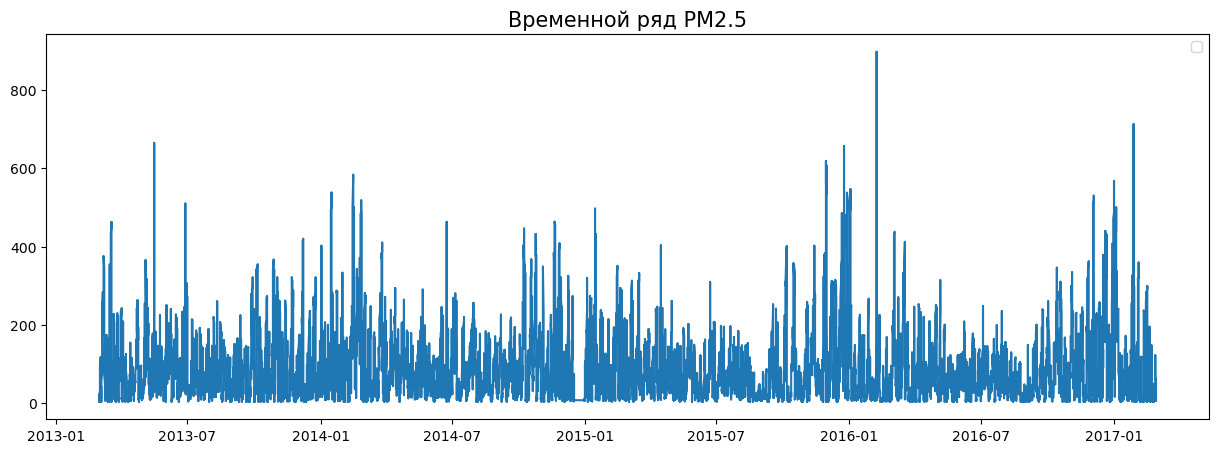

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

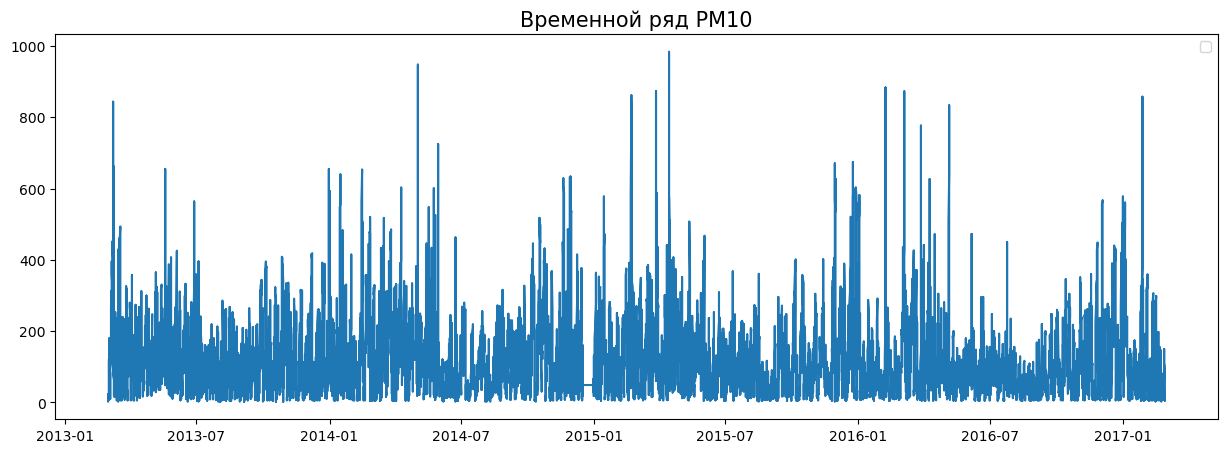

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

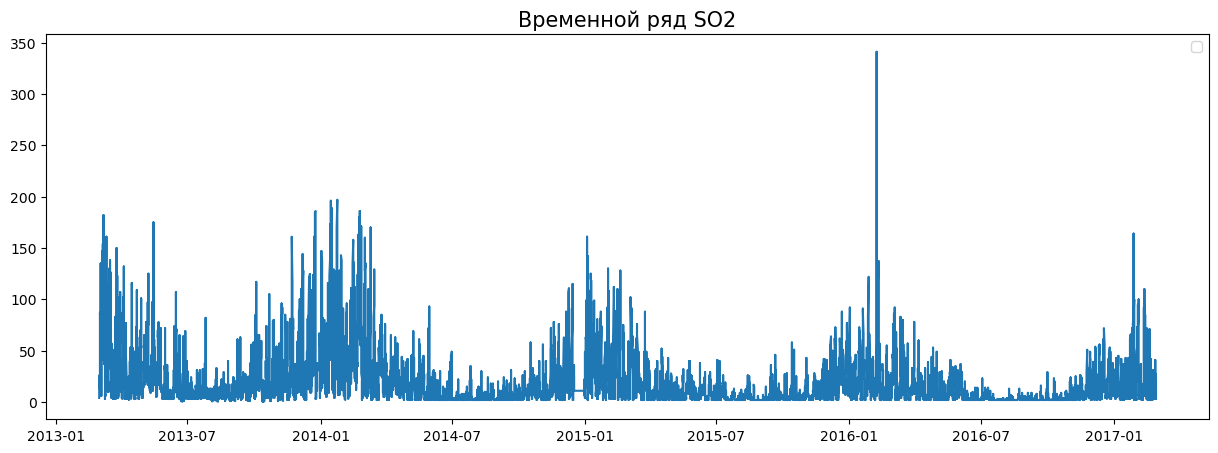

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

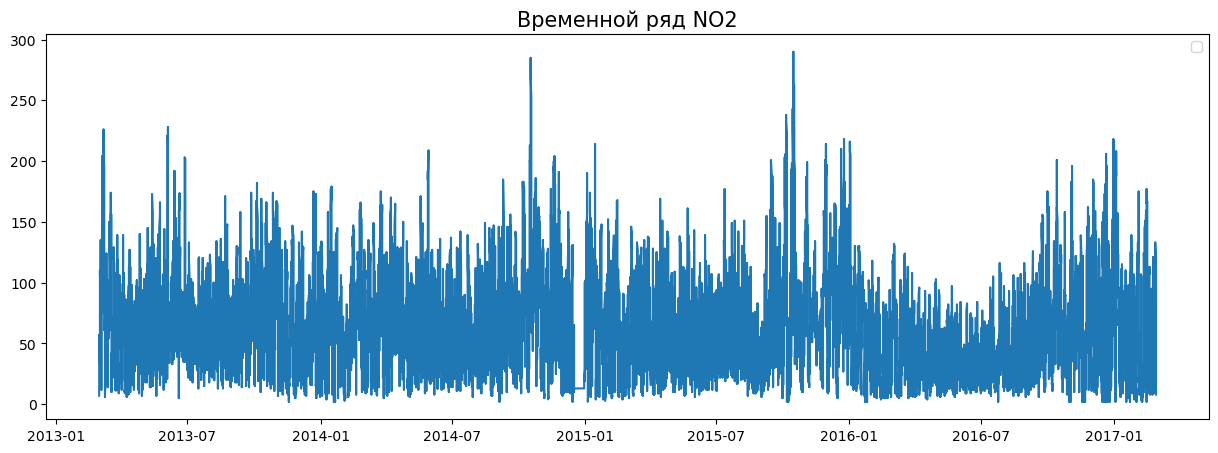

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

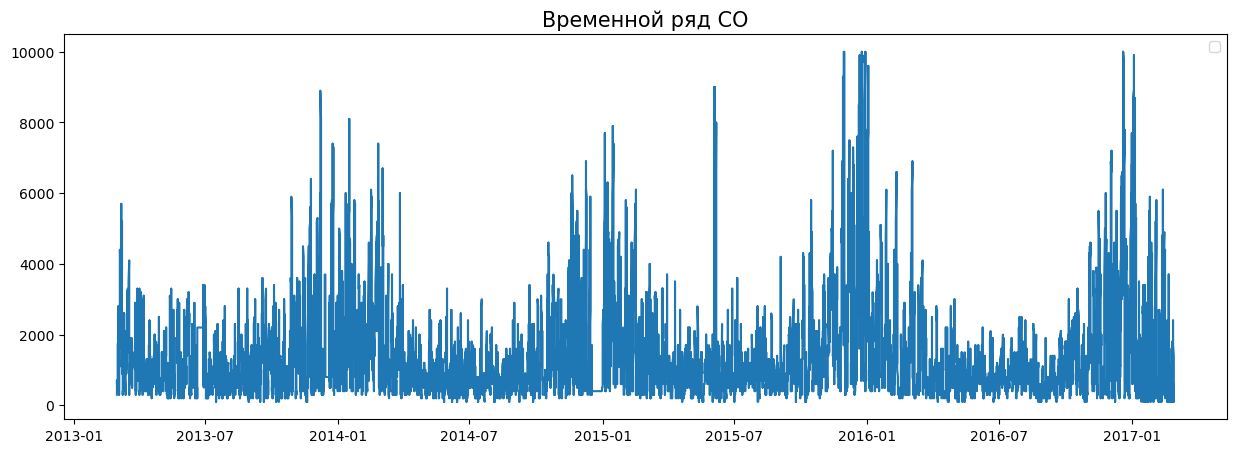

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

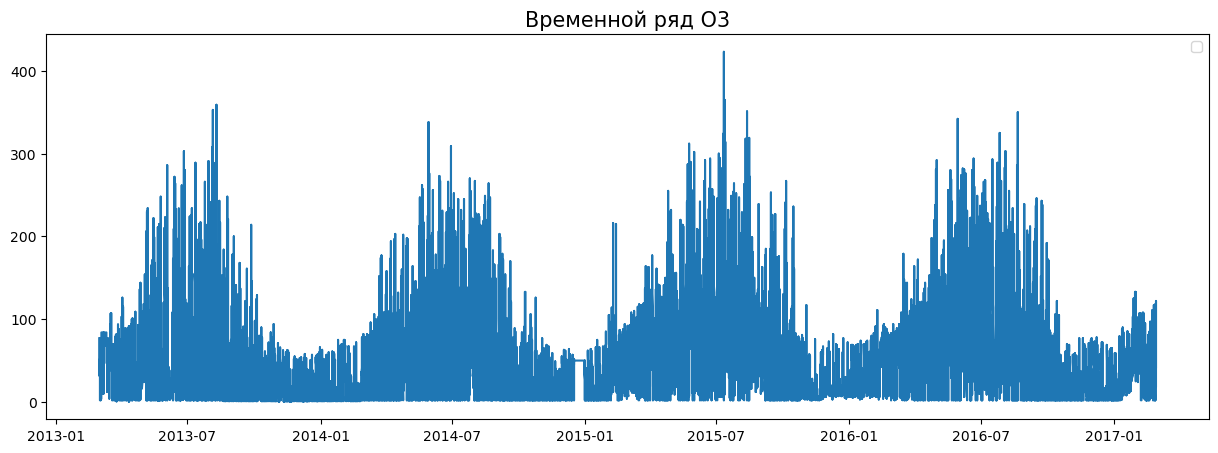

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

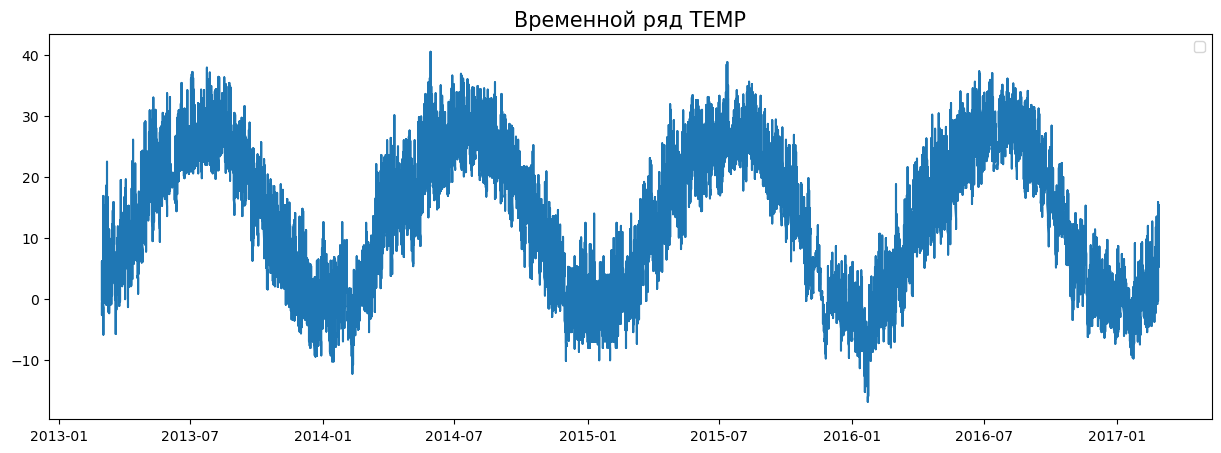

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

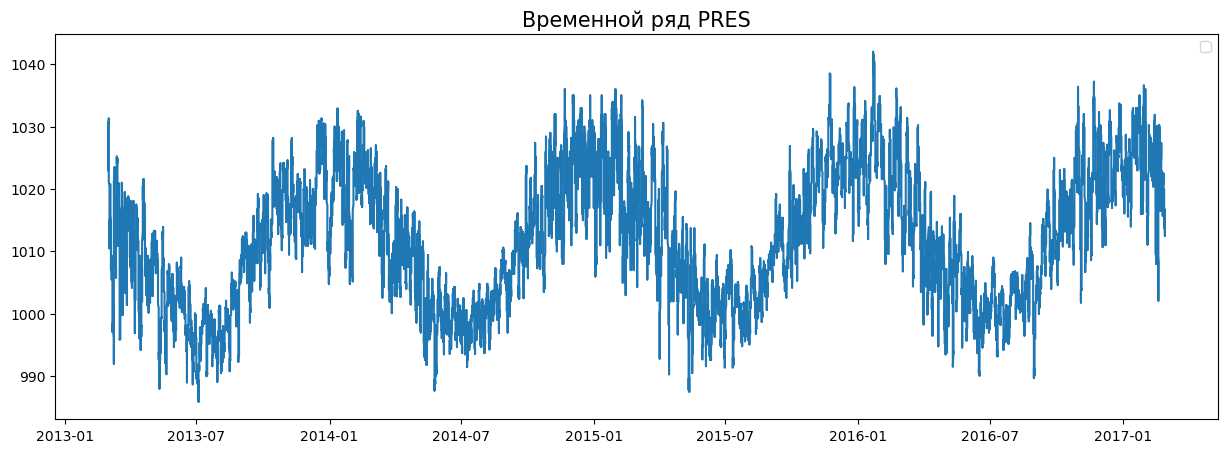

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

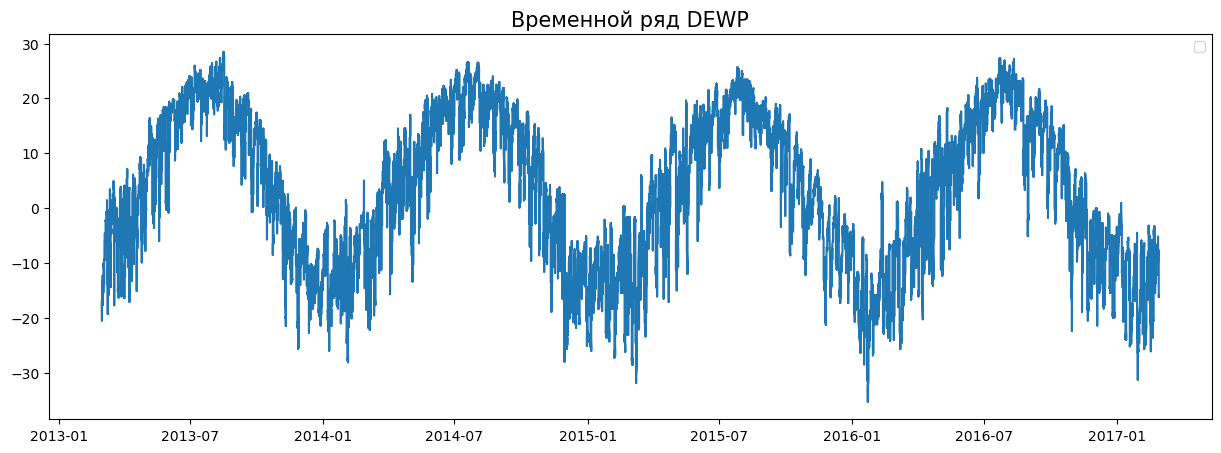

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

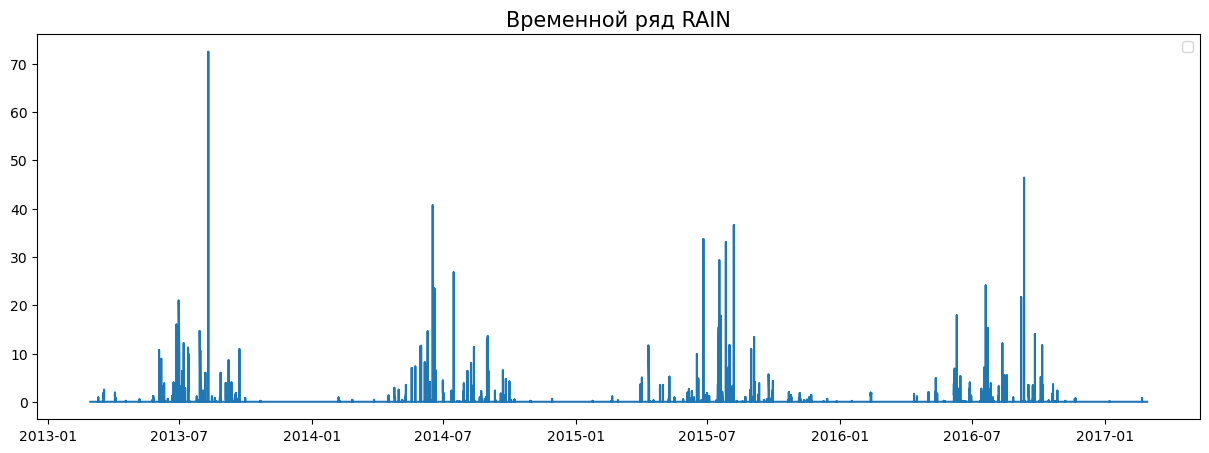

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

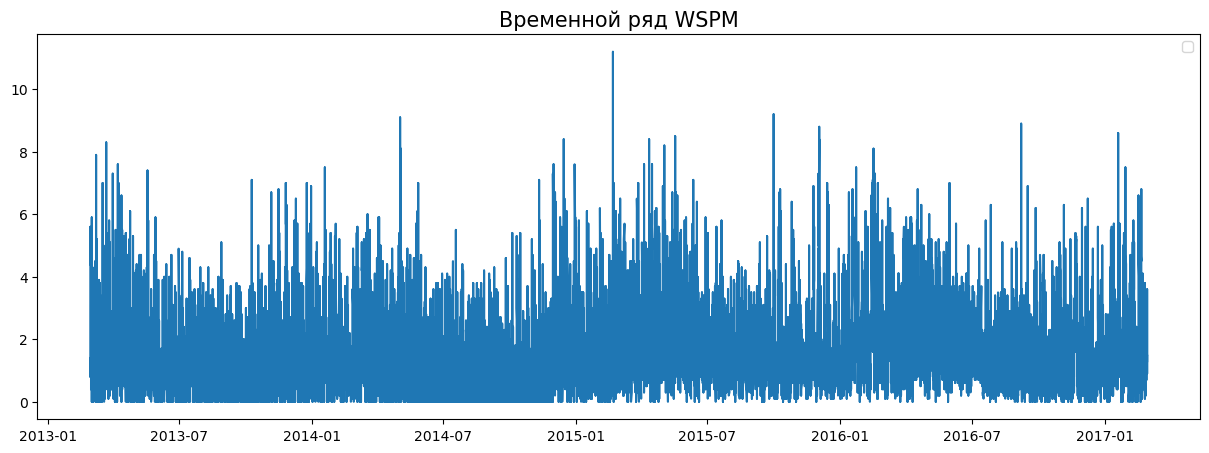

In [63]:
features = data.columns[4:]

for feature in features:
    plt.figure();
    plot_results(data[feature],_,0,"Временной ряд " + feature, is_with_test= False);

Какие закономерности вы видите на графиках?

**Ответ:**

PM2.5: годичная и месячная периодичность + есть потеря данных в декаюре 15го, как и на следующих таргетах

PM10:годичная и месячная периодичность

SO2: отчетливая годичная периодичность

NO2: годичная периодичность

CO: годичная периодичность

O3: годичная периодичность, но пик приходится на июль, а не на январь как в прошлых

ТЕМП, PRES, DEWP: годичная периодичность

RAIN: годичная периодичность

Сгенерируйте новые временные признаки, основываясь на графиках выше. Допишите функцию для создания данных со сдвигом `create_shifted_features`. Помните, что у нас данные поступают каждый час, то есть сдвиг на 1 отвечает сдвигу на 1 час, сдвиг 24 отвечает сдвигу на 1 день, сдвиг на 7*24 отвечает сдвигу на неделю. 

*Указание:* эту функцию нужно использовать для **таргета**!

In [10]:
Xt =  create_shifted_features(data.loc[:,data.columns != "PM10"])[0]

Отделите таргет от признаков. К физическим признакам добавьте временные, полученные в ячейке выше.

In [11]:
y = data['PM10']
X = Xt

In [13]:
X

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PM2.5_shift_1,PM2.5_shift_2,PM2.5_shift_3,...,RAIN_shift_5,RAIN_week_seasonal_shift_1,RAIN_year_seasonal_shift_1,WSPM_shift_1,WSPM_shift_2,WSPM_shift_3,WSPM_shift_4,WSPM_shift_5,WSPM_week_seasonal_shift_1,WSPM_year_seasonal_shift_1
date,,,,,,,,,,,,,,,,,,,,,
2014-03-01,5,1,3,2014,60,1,9,34.0,20.0,489.0,...,0.0,0.0,0.0,0.0,3.1,1.4,1.6,0.7,0.8,4.4
2014-03-01,5,1,3,2014,60,1,9,39.0,15.0,426.0,...,0.0,0.0,0.0,1.0,2.0,0.1,1.2,1.3,1.2,4.7
2014-03-01,5,1,3,2014,60,1,9,70.0,18.0,426.0,...,0.0,0.0,0.0,1.7,3.1,0.7,1.2,1.2,0.8,5.6
2014-03-01,5,1,3,2014,60,1,9,111.0,15.0,426.0,...,0.0,0.0,0.0,1.4,3.2,1.0,1.0,1.2,1.0,3.1
2014-03-01,5,1,3,2014,60,1,9,68.0,14.0,426.0,...,0.0,0.0,0.0,1.4,2.9,1.1,0.8,1.2,0.8,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28,1,1,2,2017,59,28,9,51.0,30.0,14.0,...,0.0,0.4,0.0,1.0,2.7,0.5,2.5,1.7,1.4,3.1
2017-02-28,1,1,2,2017,59,28,9,51.0,36.0,17.0,...,0.0,0.5,0.0,1.6,1.9,1.7,2.0,2.0,1.5,2.1
2017-02-28,1,1,2,2017,59,28,9,53.0,42.0,12.0,...,0.0,0.8,0.0,2.1,1.7,1.7,2.1,1.8,1.1,1.4


Разбейте ваши данные таким образом, чтобы в тесте остался последние 20% измерений.

**Замечание:** Так как далее предлагается использовать рекурсивную модель, мне придется делать выборку, исключаяя физические признаки, то есть созданные X и y больше не будут играть роли.

In [186]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
data_PM = data["PM10"]
data_train = data_PM[:-int(data_PM.shape[0]*0.2)]
data_test = data_PM[-int(data_PM.shape[0]*0.2):]
X_train, y_train = create_only_date_train_features(data_train)

Обучите линейную регрессию с регуляризацией и случайный лес на ваших данных. Допишите функцию `recursive_prediction`.  Посчитайте метрики с помощью функции `calc_metrics`.

In [187]:
model = Ridge()
model.fit(X_train, y_train)
ridge_predictions = recursive_prediction(
    model,
    data_test.index,
    data_train,
    lambda date, previous_y: create_date_features(date),
)

In [158]:
model = RandomForestRegressor(n_estimators=300)
model.fit(X_train, y_train)
forest_predictions = recursive_prediction(
    model,
    data_test.index,
    data_train,
    lambda date, previous_y: create_date_features(date),
)

Визуализируйте полученные прогнозы с помощью функции `plot_results`.

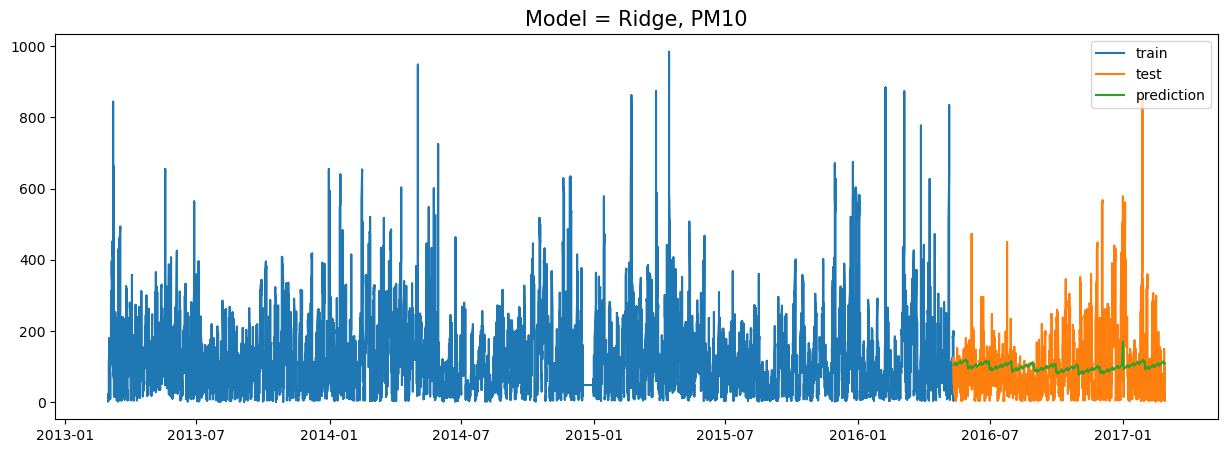

MSE:  7866.185426262194
MAE:  66.29085000131607
MAPE:  1.990663157925927


In [188]:
plot_results(data_train, data_test, ridge_predictions, title = "Model = Ridge, PM10")
calc_metrics(data_test, ridge_predictions)

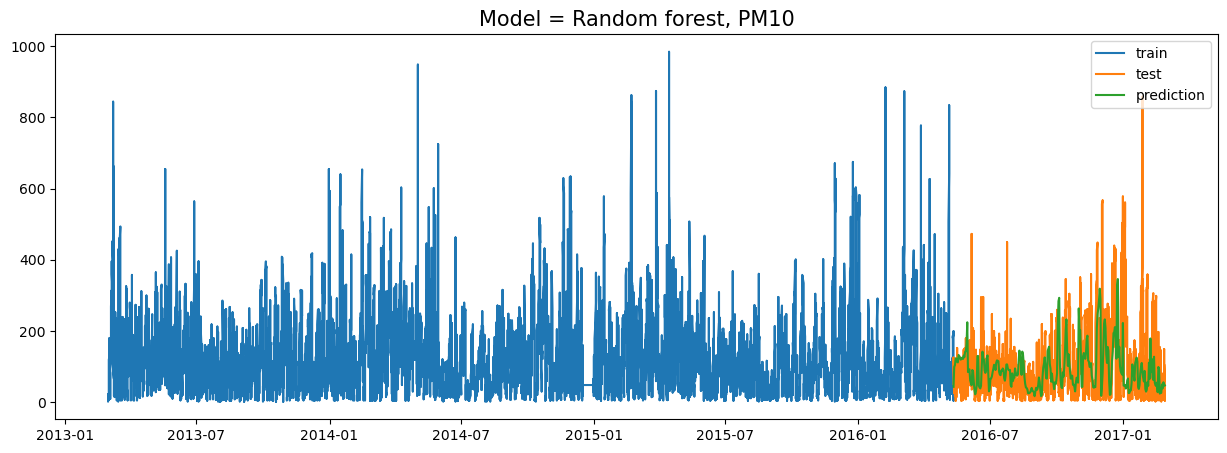

MSE:  8951.805120786454
MAE:  66.20304386012826
MAPE:  1.6493047511731014


In [159]:
plot_results(data_train, data_test, forest_predictions, title = "Model = Random forest, PM10")
calc_metrics(data_test, forest_predictions)

Сделайте выводы.

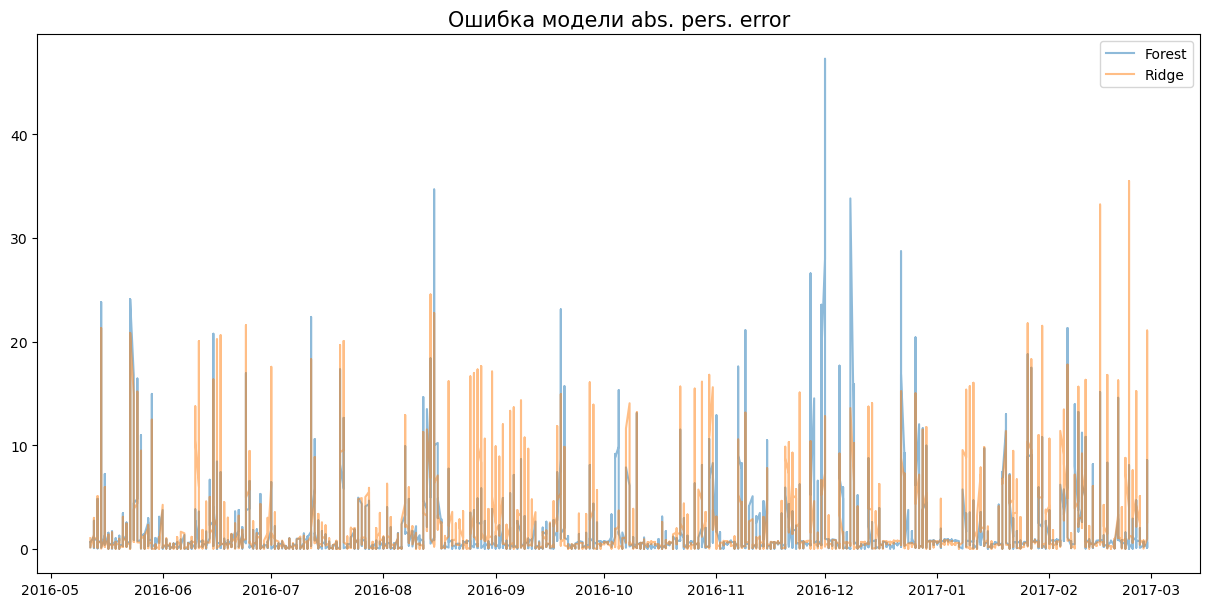

In [208]:
plt.figure(figsize=(15, 7))
plt.title("Ошибка модели abs. pers. error", fontsize=15) 
plt.plot(np.abs(forest_predictions - data_test)/data_test, label = "Forest", alpha = 0.5)
plt.plot(np.abs(ridge_predictions - data_test)/data_test, label = "Ridge", alpha = 0.5)
plt.legend();

**Вывод:** 

1) Дерево дает меньшую ошибку на тесте, чем ridge, но это не очень-то важно, потому что ошибка > 150% для обоих, что плохо

2) Из-за использования рекурсивного алгоритма пришлось отказаться от физических признаков. Можно было их использовать, если создать под каждый из них свою модель, но тогда бы ошибка накипливалась ещё быстрее, использовалось много ресурсов компьютера.

3) Я построил график Ошибки на тетовой выборке. Из-за накопления ошибок на каждой итерации ошибка должна по идее иметь возростающий тренд, но его слабо видно. 

- Для Ridge Ошибка похоже что имеет периодический (похоже на недельный) характер. 

- Для Forest не всё так плохо, но иногда случаются большие выбросы.

- Корелляция между двумя ошибками может указывать на то, что в данных есть аномалии (что видно по графикам выше), которые не могут быть предсказаны обоими моделями в силу рандомности распределения аномалий

## Задача 2

Вспомним, что при построении деревьев в задаче регрессии для каждого листа вычисляется среднее по всем обучающим объектам, которые попали в данный лист. Тем самым значение в листе лежит в пределах области значений таргета на обучении (не превосходит максимального, не меньше минимального). В связи с этим деревья не могут предсказывать значения за пределами этой области. Зависимости в задачах временных рядов не редко имеют некоторый тренд, например, значения на тестовой части временного ряда могут оказаться вне области значений обучающей части ряда. Это означает, что решающее дерево не сможет построить хороший прогноз временного ряда. Проблема также распространяется на случайный лес. 

В данной задаче вы реализуете другой способ прогнозирования временных рядов, который может решить эту проблему.

Исследуйте `Ridge`, `Lasso` и `ElasticNet` с различными параметрами на данных из предыдущей задачи. Подберите лучшую линейную модель.

In [297]:
X_test, y_test = create_only_date_train_features(data_test)

In [305]:
errors = np.zeros((21, 200))
i = 0
for l1 in np.arange(0,1.05,0.05):
    error = []
    for alpha in np.arange(0, 2, 0.01):
        model = ElasticNet(alpha = alpha, l1_ratio = l1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        error.append(mean_absolute_error(y_test, y_pred))
    errors[i] = error
    i += 1

C:\Users\AsusPro\AppData\Local\Temp\ipykernel_7568\1653247471.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train, y_train)
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.298e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+08, tolerance: 2.631e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.155e+08, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.834e+07, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.162e+07, to

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.043e+08, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.994e+07, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.006e+07, to

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.157e+08, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.535e+07, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.806e+07, to

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.116e+08, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.796e+07, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.974e+07, to

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.078e+08, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.169e+07, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.351e+07, to

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.041e+08, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.621e+07, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.851e+07, to

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.130e+07, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.423e+07, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.316e+07, to

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.065e+06, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e+06, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+05, to

C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.240e+07, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.034e+07, tolerance: 2.631e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\AsusPro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e+07, to

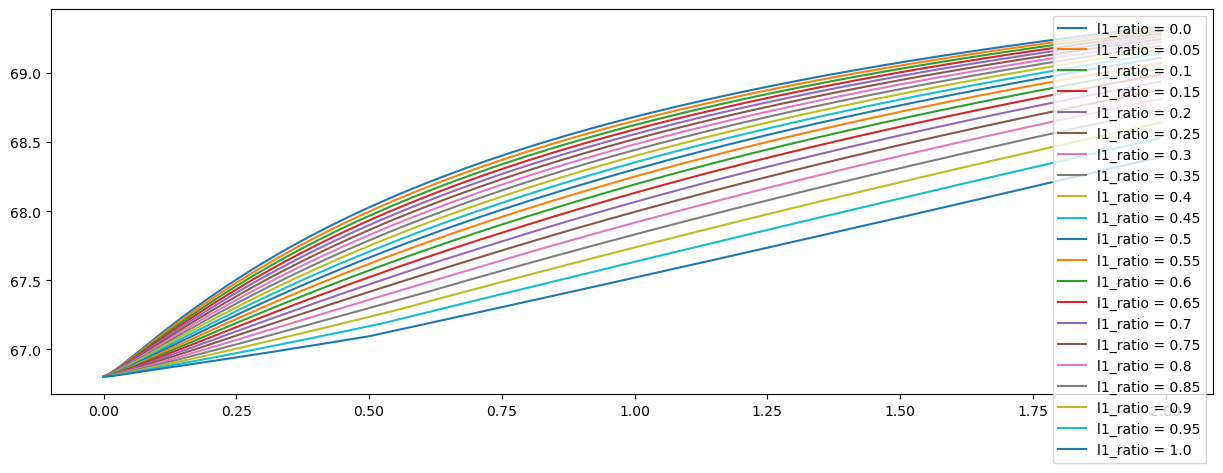

In [307]:
plt.figure(figsize=(15,5))
for i in range(21):
    plt.plot(np.arange(0, 2, 0.01), errors[i], label = f"l1_ratio = {np.float64(0.05*i).round(2)}")
plt.legend()

При росте alpha ошибка линейной модели возрастает, поэтому буду использовать просто линейную регрессию

P.S. надеюсь я правильно понял задание "Исследуйте и выберите..."

In [320]:
modellin = LinearRegression()
modellin.fit(X_train, y_train)
y_pred = modellin.predict(X_train)

Посчитайте остатки прогноза вашей модели на тренировочной выборке. Остатком является разность истинного значния и спрогнозированного.

In [316]:
errors_train = y_train - y_pred

Теперь сделаем необычный ход &mdash; научим случайный лес предсказывать ошибку линейной модели. Для этого за `Х` возьмем исходные признаки, а за `y` - вектор разностей, который вы посчитали в ячейке выше.

Предскажем ошибку линейной модели на тестовой выборке. Получим вектор предсказанных ошибок.

In [317]:
model = RandomForestRegressor(n_estimators=300)
model.fit(X_train, errors_train)
forest_predictions = recursive_prediction(
    model,
    data_test.index,
    data_train,
    lambda date, previous_y: create_date_features(date),
)

In [318]:
errors_pred = forest_predictions

Теперь сложим прогноз линейной модели для тестовой выборки и прогноз ошибок случайного леса для этой же тестовой выборки. Посчитайте метрики для полученного вектора.

In [321]:
y_pred = modellin.predict(X_test)

In [322]:
calc_metrics(y_test, y_pred+errors_pred)

MSE:  8859.977442171374
MAE:  64.5102992101471
MAPE:  1.5188615395044265


Визуализируйте новый прогноз.

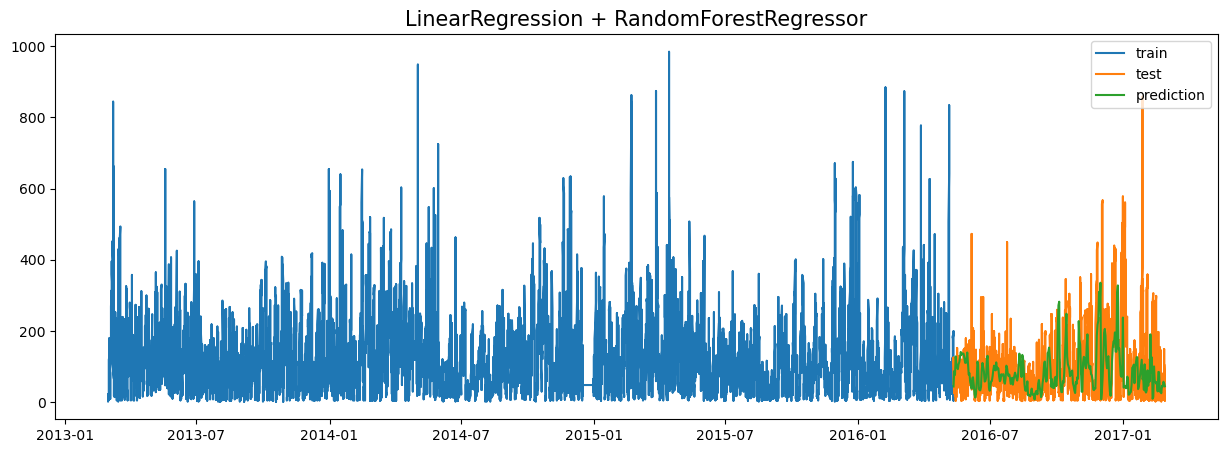

In [324]:
plot_results(data_train, data_test, y_pred+errors_pred, title = "LinearRegression + RandomForestRegressor")

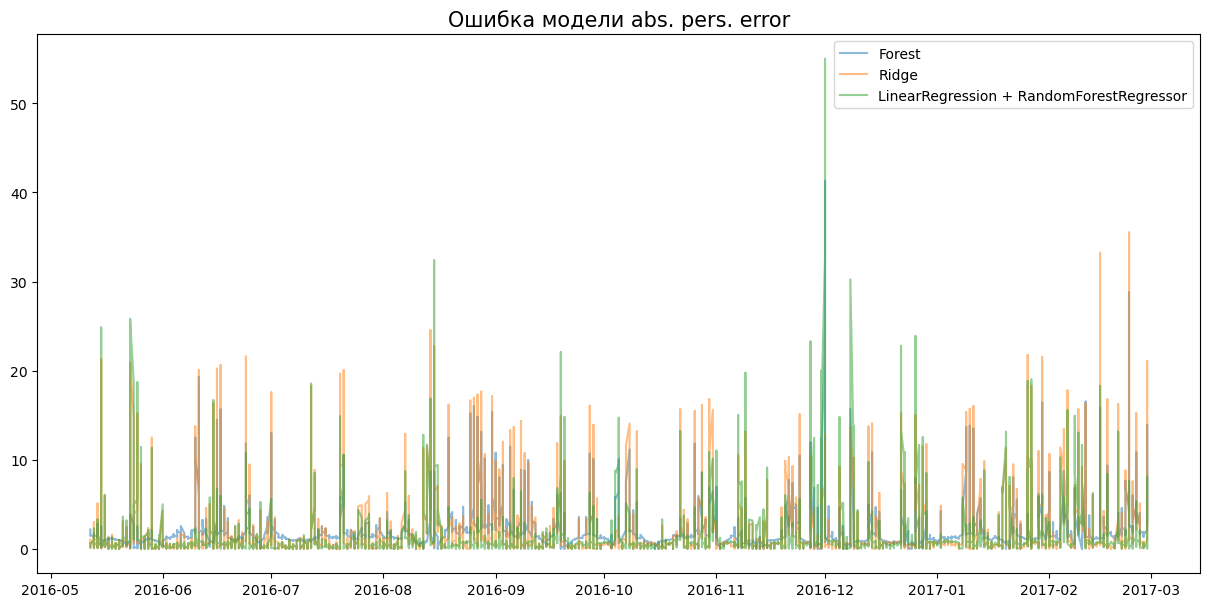

In [325]:
plt.figure(figsize=(15, 7))
plt.title("Ошибка модели abs. pers. error", fontsize=15) 
plt.plot(np.abs(forest_predictions - data_test)/data_test, label = "Forest", alpha = 0.5)
plt.plot(np.abs(ridge_predictions - data_test)/data_test, label = "Ridge", alpha = 0.5)
plt.plot(np.abs(y_pred+errors_pred - data_test)/data_test, label = "LinearRegression + RandomForestRegressor", alpha = 0.5)
plt.legend();

Сделайте вывод.

**Вывод:**

1) бустинг работает!

2) Он уменьшил ошибку, но она всё ещё велика

3) Опять видна корелляция между ошибками между собой и "выбросами" в предсказываемых данных, которые не предсказать

Процедура, которую вы сейчас провели, называется **бустинг**. В этой модели последовательно объединяются деревья, которые учатся предсказывать ошибку предыдущего дерева. Благодаря такой схеме модели удается достичь высокого качества. Подробнее с бустингом мы ознакомимся в следующем семестре.